# Trabalho Final da Discilpina de Engenharia de Software para CD - PUC-Rio

Professor: Marcos Kalinowski

Aluno: Pedro Henrique Cardoso Paulo

Data limite de entrega: 07 de junho de 2023

## Definição do problema

### Motivação

A previsão de produção de óleo ao longo do tempo é uma necessidade de qualquer operador da indústria de O&G, quer seja por obrigações legais, quer seja para poder gerenciar de forma mais adequada suas reservas. Embora essa tarefa seja corriqueiramente feita no dia-a-dia de um engenheiro de reservatórios, 

### Dataset

![fig:dataset_example](./images/data_example.png)

O Volve Dataset é uma base de dados aberta contendo dados geológicos e de histórico de produção do campo de Volve. O campo foi operado pela Equinor entre 2008 e 2016, quando sua produção foi encerrada. Em 2018 as facilidades de produção do compo foram removidas.

A parte de interesse para o presente estudo do Volve Dataset são os dados do histórico de produção de seus poços, que consistem em valores ao longo do tempo (normalmente médias diárias) de pressão, temperatura, abertura de válvulas e de vazões das três fases (água, óleo e gás) de fluido produzidas pelo poço.

### User Story

Como ENGENHEIRO DE RESERVATÓRIO quero PREVER A PRODUÇÃO DE UM POÇO BASEADO EM SEU HISTÓRICO para TOMAR DECISÕES DE PRIORIZAÇÃO E CUMPRIR COMPROMISSOS LEGAIS.

## Coleta e análise de dados

In [227]:
# Pacotes padrao
import copy
import json
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, KFold, cross_val_score

# Scores
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

# Disabling warnings
import warnings
warnings.filterwarnings("ignore")

#Definindo random_state (repetibilidade)
rs = 85

In [228]:
class DataLoader:

    def __init__(self, base_path='.'):
        """Build the DataLoader class. Takes only the base path
        where to find the data as an input.

        Args:
            base_path (str, optional): Base path yo get the  desierd
            data. Defaults to '.'.
        """

        self.base_path = base_path
        self.load_metadata(self.base_path)

    def load_metadata(self, path):
        """Loads the metadata from the dataset, that allows the query
        for the data od an specific well.

        Args:
            path (str): Path where to find the metadata
        """
        
        with open(path + '/metadata.json', 'r') as metafile:
            self.metadata = json.loads(metafile.read())

    def load_data(self, well, variables):
        """Loads the data of a given well in the dataset

        Args:
            well (str): Name of the well to be taken from the dataset
            variables (List[str]): Variables list to be taken form the dataset

        Returns:
            data (pd.DataFrame): Dataframe containing the data frm the well
        """

        # Getting the well INDEX using the parsed metadata
        try:
            well_index = [meta['INDEX'] for meta in self.metadata if meta['WELL'] == well][0]
        except Exception as e:
            print('No data loaded!')
            return None
        
        # Reading data and filtering the columns
        data = pd.read_json(f'{self.base_path}/{well_index}.json')
        data = data[variables]
        
        return data

In [229]:
path = './data'
well = '15/9-F-1 C'

input_variables = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

output_variables = [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
]

dataloader = DataLoader(base_path=path)
well_data = dataloader.load_data(well=well, variables=input_variables+output_variables)

In [230]:
display(well_data.head(10))

,AVG_DOWNHOLE_PRESSURE,AVG_WHP_P,AVG_CHOKE_SIZE_P,AVG_WHT_P,AVG_DOWNHOLE_TEMPERATURE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
0,0.000,0.000,0.00000,0.000,0.000,0.0,0.0,0.0
1,NaN,0.000,1.00306,0.000,NaN,0.0,0.0,0.0
2,NaN,0.000,0.97901,0.000,NaN,0.0,0.0,0.0
3,NaN,0.000,0.54576,0.000,NaN,0.0,0.0,0.0
4,310.376,33.098,1.21599,10.480,96.876,0.0,0.0,0.0
5,303.501,22.053,3.08702,8.704,96.923,0.0,0.0,0.0
6,303.535,27.503,1.96237,9.423,96.959,0.0,0.0,0.0
7,303.782,20.996,0.00000,8.131,96.969,0.0,0.0,0.0
8,303.858,13.918,31.14186,8.498,97.021,0.0,0.0,0.0
9,303.792,4.120,0.00000,8.821,97.066,0.0,0.0,0.0


In [231]:
well_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AVG_DOWNHOLE_PRESSURE     743 non-null    float64
 1   AVG_WHP_P                 746 non-null    float64
 2   AVG_CHOKE_SIZE_P          746 non-null    float64
 3   AVG_WHT_P                 746 non-null    float64
 4   AVG_DOWNHOLE_TEMPERATURE  743 non-null    float64
 5   BORE_OIL_VOL              746 non-null    float64
 6   BORE_GAS_VOL              746 non-null    float64
 7   BORE_WAT_VOL              746 non-null    float64
dtypes: float64(8)
memory usage: 46.8 KB


In [232]:
well_data.describe()

,AVG_DOWNHOLE_PRESSURE,AVG_WHP_P,AVG_CHOKE_SIZE_P,AVG_WHT_P,AVG_DOWNHOLE_TEMPERATURE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
count,743.000000,746.000000,746.000000,746.000000,743.000000,746.000000,746.000000,746.00000
mean,246.666036,53.908149,29.598451,40.409042,104.925303,218.332233,36.596588,233.54171
std,30.753351,32.967226,25.483084,26.115960,6.448725,245.183559,44.595590,309.45189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,220.870500,32.184000,0.024875,11.218750,101.274500,0.000000,0.000000,0.00000
50%,240.638000,43.263000,46.546070,53.302500,107.820000,174.000000,31.106500,1.41500
75%,271.226500,74.800250,51.153708,62.364500,108.139500,361.500000,57.624000,337.75000
max,313.871000,133.593000,93.635430,83.420000,108.502000,970.000000,521.000000,991.00000


<Axes: >

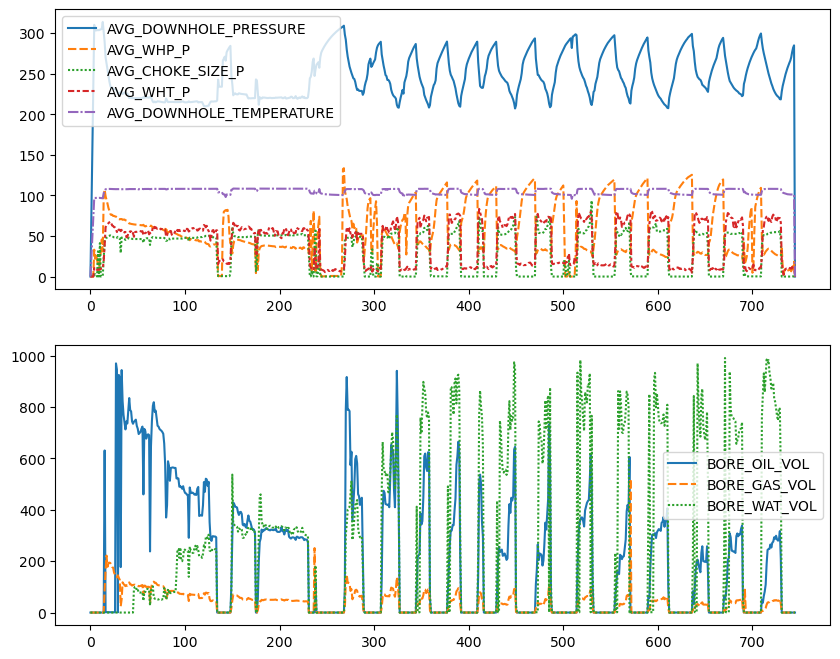

In [233]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
sns.lineplot(well_data[input_variables], ax=ax[0])
sns.lineplot(well_data[output_variables], ax=ax[1])


## Pré-processamento

In [234]:
class PreProcessor:

    def preprocess(self, dataset, holdout, input_variables, output_variables, clean_data=True):

        if clean_data:
            dataset = self.__clean_dataset(dataset)
        
        dataset_train, dataset_test = self.__holdout(dataset, holdout)

        X_train, y_train = self.__separate_input_output(dataset_train, input_variables, output_variables)
        X_test, y_test = self.__separate_input_output(dataset_test, input_variables, output_variables)

        return X_train, y_train, X_test, y_test
        

    def __clean_dataset(self, dataset):

        dataset = dataset.dropna()
        dataset = dataset.loc[~(dataset==0).all(axis=1)]
        return dataset
    
    def __holdout(self, dataset, holdout):
        
        total_samples = len(dataset)
        train_samples = int(total_samples*(1.0-holdout))
        dataset_train = dataset.iloc[:train_samples,:]
        dataset_test = dataset.iloc[train_samples:,:]

        return dataset_train, dataset_test

    def __separate_input_output(self, dataset, input_variables, output_variables):

        X = dataset[input_variables].values
        y = dataset[output_variables].values.ravel()

        return X, y
    



In [235]:
preprocessor = PreProcessor()

X_train, y_train, X_test, y_test = preprocessor.preprocess(well_data, holdout=0.3, input_variables=input_variables, output_variables=output_variables[:1])

In [236]:
display(X_train)

array([[310.376  ,  33.098  ,   1.21599,  10.48   ,  96.876  ],
       [303.501  ,  22.053  ,   3.08702,   8.704  ,  96.923  ],
       [303.535  ,  27.503  ,   1.96237,   9.423  ,  96.959  ],
       ...,
       [250.729  ,  36.696  ,  53.287  ,  71.531  , 108.086  ],
       [247.68   ,  36.228  ,  53.28875,  70.847  , 108.084  ],
       [245.182  ,  35.344  ,  53.2937 ,  69.525  , 108.066  ]])

## Modelagem e inferência

In [237]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)),
    ('PolyReg'         ,      Pipeline([('Expander', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])),
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
]

In [238]:
scalers = [
    ('Robust'  , RobustScaler()),
    ('MinMax'  , MinMaxScaler()),
    ('Standard', StandardScaler()),
]

In [239]:
model_parameters = [
    {
        'LinReg__positive'                     : [True, False],
    },
    {
        'PolyReg__Reg__positive'                : [True, False],
        'PolyReg__Expander__degree'             : [2, 3],
    },
    {
        'SVM__C'                     : stats.loguniform(1e-3, 1e3),
        'SVM__kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'SVM__degree'                : stats.randint(2,6),
        'SVM__gamma'                 : stats.loguniform(1e-4, 1e0),
    },
    {
        'KNN__n_neighbors'           : stats.randint(1,100),
        'KNN__weights'               : ['uniform', 'distance'],

    },
    {

        'DecisionTree__splitter'               : ['best', 'random'],
        'DecisionTree__max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'DecisionTree__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'DecisionTree__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'DecisionTree__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'DecisionTree__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas

    },
    {
        'RandomForest__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'RandomForest__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'RandomForest__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'RandomForest__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'RandomForest__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'RandomForest__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
    {
        'GradientBoosting__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'GradientBoosting__loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'GradientBoosting__learning_rate'          : stats.loguniform(1e-5, 1e1),
        'GradientBoosting__criterion'              : ['friedman_mse', 'squared_error'],
        'GradientBoosting__subsample'              : stats.uniform(), 
        'GradientBoosting__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'GradientBoosting__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'GradientBoosting__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'GradientBoosting__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'GradientBoosting__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
    {
        'ExtraTrees__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'ExtraTrees__criterion'              : ['squared_error', 'absolute_error'],
        'ExtraTrees__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'ExtraTrees__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'ExtraTrees__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'ExtraTrees__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'ExtraTrees__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
]

In [240]:
pipelines = []

# PIPELINES com apenas o modelo

for model, parameters in zip(models_ml, model_parameters):
    name = model[0]
    pipeline = Pipeline([model])
    pipelines.append((name, pipeline, parameters))


# PIPELINES com scaler
for model, parameters in zip(models_ml, model_parameters):
    for scaler in scalers:
        name = f'{scaler[0]}_{model[0]}'
        pipeline = Pipeline([scaler, model])
        pipelines.append((name, pipeline, parameters))

In [241]:
class EvaluateCV:

    def perform_cross_validation(self, model_list, X_train, y_train, cv, score):

        results, names = [], []
        for model_tuple in tqdm(model_list):
            name, model = model_tuple[0], model_tuple[1]
            cv_results = cross_val_score(copy.deepcopy(model), X_train, y_train, cv=cv, scoring=score)
            names.append(name)
            results.append(cv_results)

        return results, names

class ResultsCVPlotter:

    def plot_cross_val_results(self, results, names):

        fig, ax = plt.subplots(1,1)
        ax.boxplot(results)
        ax.set_xticklabels(names, rotation=90)

class ResultsCVPrinter:

    def print_cross_val_results(self, results, names):

        for result, name in zip(results, names):

            print(f'CV Results for model {name}: {np.mean(result)} (sd. {np.std(result)})')
            

In [242]:
compareCV = EvaluateCV()
cv = KFold(n_splits = 5, shuffle = False)
scorer = make_scorer(r2_score)
results, names = compareCV.perform_cross_validation(pipelines, X_train, y_train, cv=cv, score=scorer)

100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


In [243]:
printer = ResultsCVPrinter()
printer.print_cross_val_results(results, names)

CV Results for model LinReg: 0.3207326075596817 (sd. 0.31512570642761706)
CV Results for model PolyReg: 0.35148789547888964 (sd. 0.36461820922728655)
CV Results for model SVM: -0.3583512489453872 (sd. 0.39572288528494265)
CV Results for model KNN: 0.5891981607512808 (sd. 0.3064558379782939)
CV Results for model DecisionTree: 0.1339904436029061 (sd. 0.8243075464447077)
CV Results for model RandomForest: 0.5947991311862577 (sd. 0.30925765443168085)
CV Results for model GradientBoosting: 0.5495330847968856 (sd. 0.3367726242244817)
CV Results for model ExtraTrees: 0.6241669337679763 (sd. 0.2951726885444705)
CV Results for model Robust_LinReg: 0.3207326075596791 (sd. 0.31512570642761834)
CV Results for model MinMax_LinReg: 0.3207326075596799 (sd. 0.3151257064276182)
CV Results for model Standard_LinReg: 0.32073260755968014 (sd. 0.31512570642761817)
CV Results for model Robust_PolyReg: 0.3514878954789398 (sd. 0.36461820922771704)
CV Results for model MinMax_PolyReg: 0.35148789547893905 (sd. 

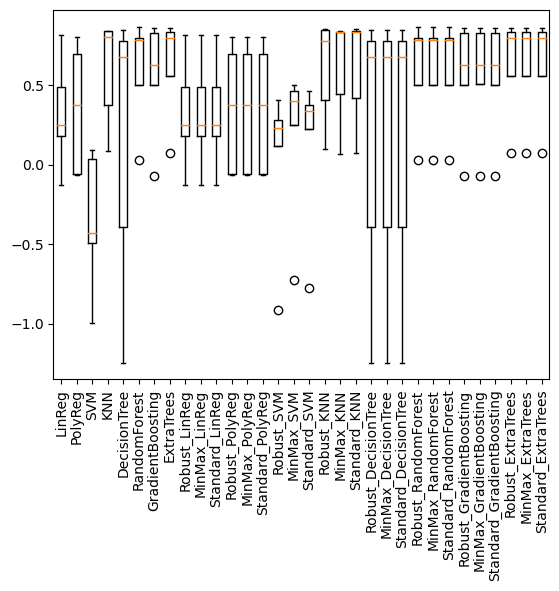

In [244]:
plotter = ResultsCVPlotter()
plotter.plot_cross_val_results(results, names)

### Hyperparameter Search

In [245]:
class RandomizedHyperParameterSearch:

    def search_best_hyperparameters(self, model_list, X_train, y_train, cv, score, iters, jobs=1):

        best_models = []
        for model_tuple in tqdm(model_list):
            name, model, parameters = model_tuple[0], model_tuple[1], model_tuple[2]
            rdmsearch = RandomizedSearchCV(
                model, verbose=0, scoring=score, 
                param_distributions=parameters, 
                n_iter=iters, n_jobs=jobs, 
                cv=cv, random_state=rs)
            rdmsearch.fit(X_train, y_train)
            best_model = rdmsearch.best_estimator_
            best_params = rdmsearch.best_params_
            best_models.append((name, best_model, best_params))

        return best_models

In [246]:
pipelines = [pipeline for pipeline in pipelines if 'SVM' not in pipeline[0]]

In [247]:
n_iterations = 100
hyperparameter_search = RandomizedHyperParameterSearch()
best_models = hyperparameter_search.search_best_hyperparameters(pipelines, X_train, y_train, cv=cv, score=scorer, iters=n_iterations)

100%|██████████| 28/28 [06:32<00:00, 14.03s/it]


In [248]:
results, names = compareCV.perform_cross_validation(best_models, X_train, y_train, cv=cv, score=scorer)

100%|██████████| 28/28 [00:10<00:00,  2.62it/s]


In [249]:
printer.print_cross_val_results(results, names)

CV Results for model LinReg: 0.4305808647920978 (sd. 0.3294116503513302)
CV Results for model PolyReg: 0.6288069476704305 (sd. 0.3015911219305221)
CV Results for model KNN: 0.6365690194365676 (sd. 0.26688405652566194)
CV Results for model DecisionTree: 0.6543346575940071 (sd. 0.21059758664062414)
CV Results for model RandomForest: 0.6915555588209843 (sd. 0.1813321874328034)
CV Results for model GradientBoosting: 0.7003787329429334 (sd. 0.19475453376993995)
CV Results for model ExtraTrees: 0.6349726109290488 (sd. 0.2582441878353283)
CV Results for model Robust_LinReg: 0.4305808647920939 (sd. 0.3294116503513292)
CV Results for model MinMax_LinReg: 0.4305808647920927 (sd. 0.3294116503513291)
CV Results for model Standard_LinReg: 0.43058086479209357 (sd. 0.329411650351329)
CV Results for model Robust_PolyReg: 0.5974589097402133 (sd. 0.3299051240178409)
CV Results for model MinMax_PolyReg: 0.6210138685753993 (sd. 0.3012715450850518)
CV Results for model Standard_PolyReg: 0.5799431730841073 

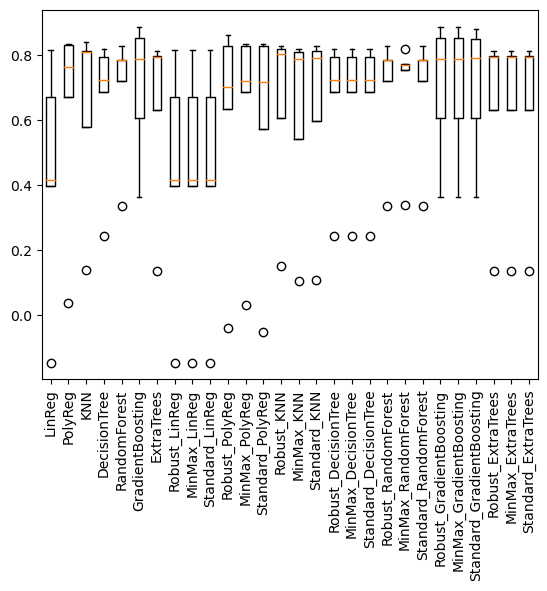

In [250]:
plotter = ResultsCVPlotter()
plotter.plot_cross_val_results(results, names)

## Pos-processamento

In [251]:
class Evaluator:

    def __init__(self, verbose=False):

        self.verbose = verbose

    def evaluate_models(self, models, X_train, y_train, X_test, y_test, metrics):

        results = {
            'MODEL':[],
        }

        for metric_name, _ in metrics:
            results[metric_name + '_TRAIN'] = []
            results[metric_name + '_TEST'] = []

        for model_tuple in models:
            name, model = model_tuple[0], model_tuple[1]
            results['MODEL'].append(name)
            if self.verbose:
                print(f'Model {name} results:')
                print(' ', *[f'Metric {metric_name} = {metric(y_train, model.predict(X_train))} in train set' for metric_name, metric in metrics])
                print(' ', *[f'Metric {metric_name} = {metric(y_test, model.predict(X_test))} in test set' for metric_name, metric in metrics])
            
            for metric_name, metric in metrics:
                results[metric_name + '_TRAIN'].append(metric(y_train, model.predict(X_train)))
                results[metric_name + '_TEST'].append(metric(y_test, model.predict(X_test)))

        return pd.DataFrame(results)
    
class GraphicalEvaluator:


    def plot_prediction_comparison(self, models, X_train, y_train, X_test, y_test):

        for model_tuple in models:
            name, model = model_tuple[0], model_tuple[1]
            
            fig, ax   = plt.subplots(1,1, figsize=(12,7))

            number_of_train_samples = len(y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            y_total = y_train.tolist() + y_test.tolist()
            number_of_total_samples = len(y_total)
            y_total_pred = y_train_pred.tolist() + y_test_pred.tolist()

            ax.plot(y_total_pred, 'r', label='PREDICTED DATA')
            ax.plot(y_total, 'k--', label='REAL DATA')

            ax.fill_between(
                np.arange(0, number_of_total_samples), np.min(y_total), np.max(y_total), 
                where = np.arange(0, number_of_total_samples) <= number_of_train_samples,
                facecolor ='grey', alpha = 0.25,
                label='Test data region')
            
            ax.set_title(name)
            ax.set_xlim(0,None)
            ax.set_ylim(np.min(y_total), np.max(y_total))
            ax.legend()





In [252]:
metrics = [
    ('R2', r2_score),
    ('MSE', mean_squared_error),
    ('MAE', mean_absolute_error),
    ]

evaluator = Evaluator()
results = evaluator.evaluate_models(best_models, X_train, y_train, X_test, y_test, metrics)
display(results.sort_values(by='MAE_TEST', ascending=True))

,MODEL,R2_TRAIN,R2_TEST,MSE_TRAIN,MSE_TEST,MAE_TRAIN,MAE_TEST
5,GradientBoosting,0.960338,0.899020,2785.551412,2270.152057,12.774983,26.388911
24,Standard_GradientBoosting,0.960137,0.895911,2799.688872,2340.046524,12.907618,26.762794
23,MinMax_GradientBoosting,0.964029,0.893800,2526.282539,2387.499891,12.565979,27.198640
22,Robust_GradientBoosting,0.964029,0.893586,2526.282539,2392.310031,12.565979,27.228432
21,Standard_RandomForest,0.922004,0.813228,5477.812586,4198.858380,33.819229,37.099163
4,RandomForest,0.922019,0.813225,5476.774725,4198.926650,33.812392,37.100134
19,Robust_RandomForest,0.922035,0.813225,5475.652577,4198.926650,33.809073,37.100134
3,DecisionTree,0.905028,0.809676,6670.048611,4278.702749,37.767503,37.119862
18,Standard_DecisionTree,0.905028,0.809676,6670.048611,4278.702749,37.767503,37.119862
17,MinMax_DecisionTree,0.905028,0.809676,6670.048611,4278.702749,37.767503,37.119862


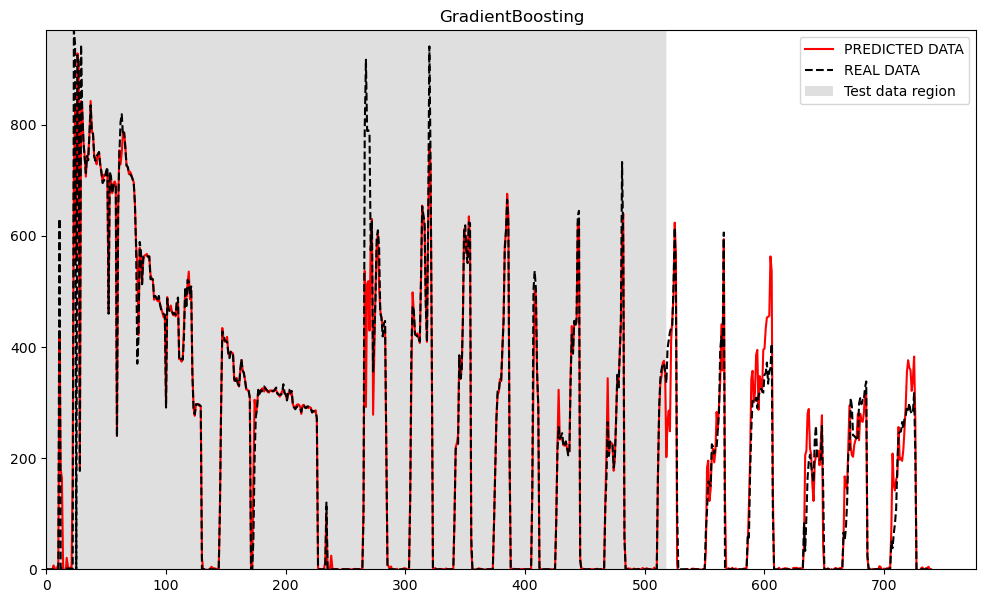

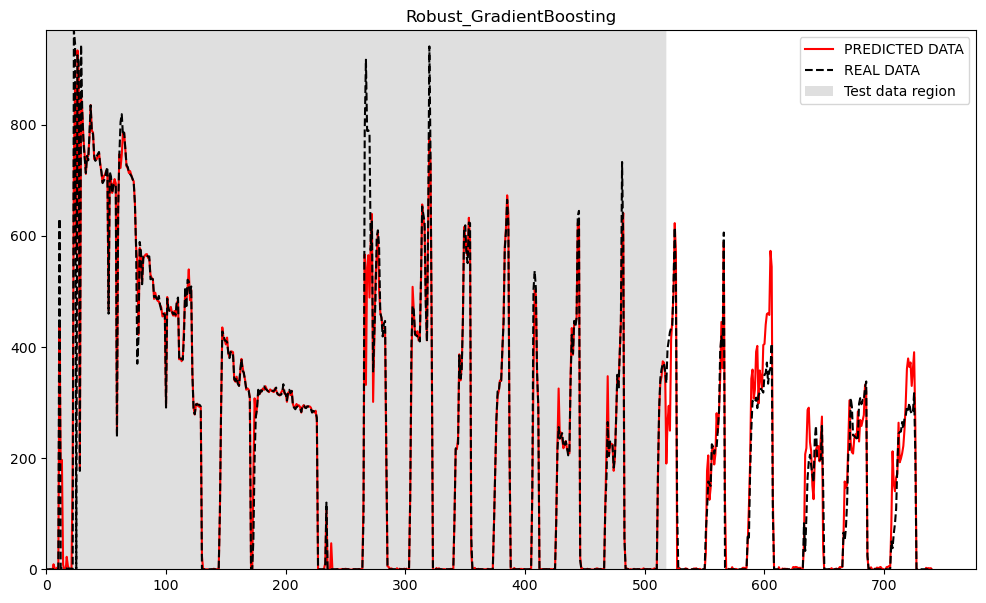

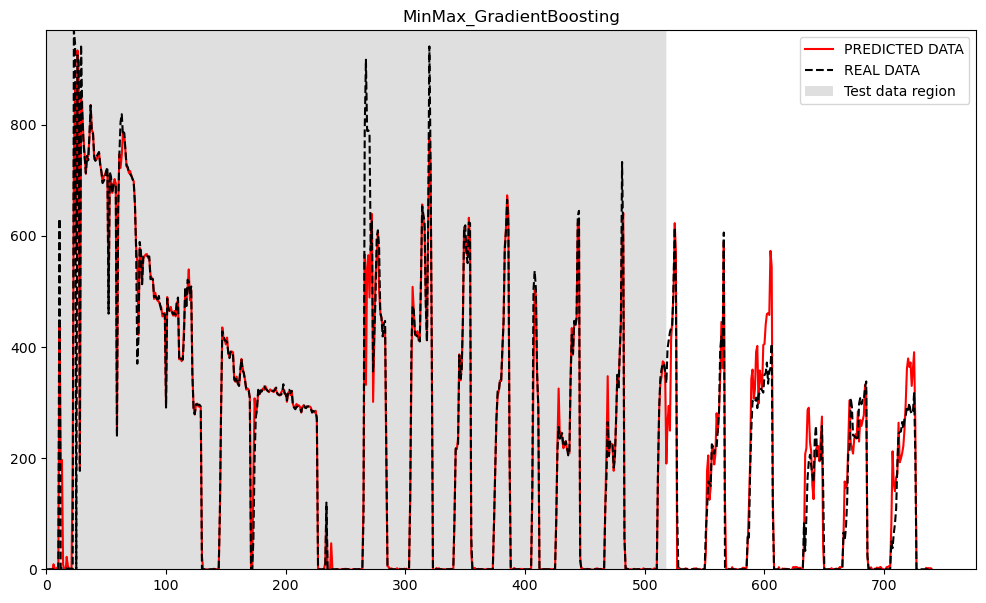

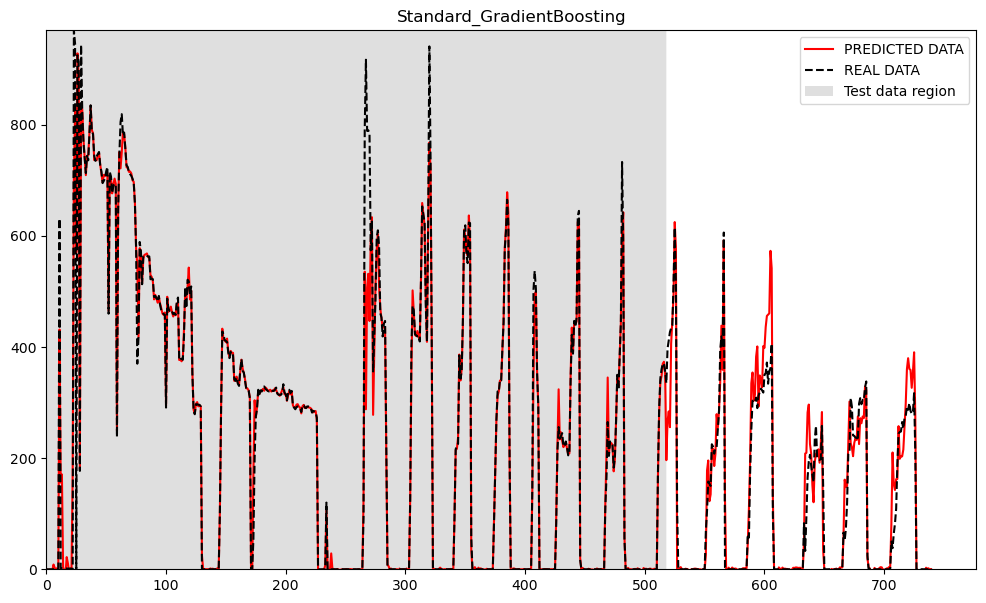

In [253]:
graphical_evaluator = GraphicalEvaluator()

plot_models = [model for model in best_models if 'GradientBoosting' in model[0]]

graphical_evaluator.plot_prediction_comparison(plot_models, X_train, y_train, X_test, y_test)